<a href="https://colab.research.google.com/github/katirasole/text_classification/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification

By Katira Soleymanzadeh

In this notebook, BERT pre-trained model for Turkish [1] is utilized and is fine-tunedfor text classification task. To accomplish this task, the Huggingface library is used [2].

[1] https://github.com/stefan-it/turkish-bert

[2] https://huggingface.co/dbmdz/bert-base-turkish-cased 


#Install requirements and Import libraries

Install required packages first and then import necessary libraries. 

In [1]:
!pip install transformers

     |████████████████████████████████| 1.1MB 5.0MB/s 
     |████████████████████████████████| 890kB 16.9MB/s 
     |████████████████████████████████| 1.1MB 29.2MB/s 
     |████████████████████████████████| 3.0MB 43.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=d52a890912fbb6c2656730ce0872b99bfe2021f6675e7378f63ab1b5669efacd
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# encoding=utf-8
import pandas as pd
import numpy as np
import time
import csv
import os
import random
import datetime
import operator
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import (BertForSequenceClassification, 
                          BertTokenizer, 
                          AdamW, 
                          BertConfig, 
                          get_linear_schedule_with_warmup,
                         )
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

## Using Colab GPU


To use Google Colab GPU, you can enable it as follows:

Runtime 🡒 Change runtime type

then a window will open and you can use GPU or TPU. 

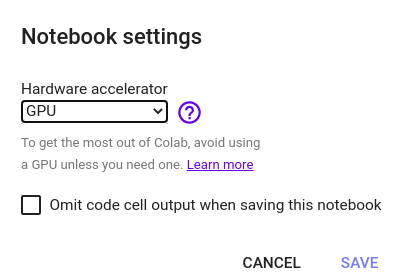

In [3]:
# Check the available GPU and use it if it is exist. Otherwise use CPU
if torch.cuda.is_available():        
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('CPU is exist.')

GPU: Tesla P100-PCIE-16GB


# Download Dataset


Clone the github repository and mount the google drive to access the data. 


In [4]:
if not os.path.exists('./text_classification'):
    print("---Cloning the repo start---")
    !git clone https://github.com/katirasole/text_classification.git
else:
    print("---The repo is already exist---")

---Cloning the repo start---
Cloning into 'text_classification'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 43 (delta 13), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (43/43), done.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls

drive  sample_data  text_classification


## Data

Split the data into train and test data. 

In [7]:
# read the dataset and then split into train and test data
filename = ('./text_classification/data/sample_complaint_data_90k.csv')
data = pd.read_csv(filename)

#=================================Split train/test/dev ============================
xTrain, xTest = train_test_split(data, test_size = 0.1, random_state = 0)

#--------------------write train/test/dev---------------------------------

def write (data, path):
    print("---Writing starts---") 
    text = data.text.values
    category = data.category.values
    row_data = {'text':text, 'category':category}
    df = pd.DataFrame(row_data, columns = ['text', 'category'])
    df.to_csv(path)
    print("---Writing ends---") 
    return 

# Write the files if there are not exist 
if not os.path.exists('./text_classification/data/train.csv' and './text_classification/data/test.csv'):
    writeFileTrain = ('./text_classification/data/train.csv')
    writeFileTest = ('./text_classification/data/test.csv')
    write(xTrain, writeFileTrain)
    write(xTest, writeFileTest)


In [8]:
# ----------Data-------------    
data_dir = "./text_classification/data/"

train_file = (data_dir + 'train.csv')
test_file = (data_dir + 'test.csv')

print("---Read data---")
#-----------------train file-------------------------
train_data = pd.read_csv(train_file)

train_text = train_data.text.values
train_category = train_data.category.values

#-----------------test file-------------------------
test_data = pd.read_csv(test_file)

test_text = test_data.text.values
test_category = test_data.category.values

print("---Complete reading data---")

---Read data---
---Complete reading data---


In [9]:
# Convert non-numeric labels to numeric labels. 
categories = ('hesap','iade', 'iptal','kredi', 'kredi-karti', 'musteri-hizmetleri')
le = preprocessing.LabelEncoder()

def numeric_category(train_category, test_category):
    categories_df = pd.DataFrame(categories, columns=['category'])
    categories_df['labels'] = le.fit_transform(categories_df['category'])
    le.fit(train_category)
    le.fit(test_category)
    train_labels = le.transform(train_category)
    test_labels = le.transform(test_category)
    return train_labels, test_labels, categories_df

train_labels, test_labels, categories_df = numeric_category(train_category, test_category)

print("Convert non-numeric labels to numeric labels\n")
print(categories_df.sort_values(by='category', ascending=True))

Convert non-numeric labels to numeric labels

             category  labels
0               hesap       0
1                iade       1
2               iptal       2
3               kredi       3
4         kredi-karti       4
5  musteri-hizmetleri       5


# Text Tokenization

Text Tokenization with BERT tokenizer. BERT model add special tokenes [CLS] and [SEP] to the begin and end of sequence.
Specify the maximum sequence length of the dataset to pad or truncate the sequence.

Pre-trained BERT models for Turkish:

*   dbmdz/bert-base-turkish-128k-uncased
*   dbmdz/bert-base-turkish-128k-cased
*   dbmdz/bert-base-turkish-uncased
*   dbmdz/bert-base-turkish-cased





In [10]:
#Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")   

In [11]:
#Specify maximum sequence length to pad or truncate
max_len = 0

for seq in train_text:
    # Tokenize the text by BERT tokenizer
    input_ids = tokenizer.encode(seq, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sequence length    ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Max sequence length     854


Using tokenizer.encode_plus to get the following items:

*   WordPiece based text tokenization
*   Add [CLS] and [SEP] special tokens to the begin and the end of sequence
*   Mapping tokens to their IDs
*   Pad or truncate the sequence to the maximum length
*   Prepare attantion masks for [PAD] tokens
*   Truncation to truncate sequence to a specified maximum length







In [12]:
# Tokenize all of the sequences and map the tokens to thier IDs.
input_ids_train = []
attention_masks_train = []

# For every sequences
for seq in train_text:
    encoded_dict = tokenizer.encode_plus(
                        seq,                             # Sequence to encode
                        add_special_tokens = True,       # Add '[CLS]' and '[SEP]'
                        max_length = 128,                
                        padding = 'max_length',          # Pad and truncate
                        truncation=True,                 #Truncate the seq
                        return_attention_mask = True,    # Construct attn. masks
                        return_tensors = 'pt',           # Return pytorch tensors
                   )
    
    # Add the encoded sequences to the list    
    input_ids_train.append(encoded_dict['input_ids'])

    # And its attention mask
    attention_masks_train.append(encoded_dict['attention_mask'])
    
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
train_labels = torch.tensor(train_labels)


Split train data to use 90% as trian and 10% as  validation set in the model training phase


In [13]:
# Change to TensorDataset and Split to train and validation sets (90-10)
dataset = TensorDataset(input_ids_train, attention_masks_train, train_labels) 
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('training set', format(train_size))
print('validation set', format(val_size))

training set 72900
validation set 8100


#Classification Model

Specify batch size. In fine-tuning BERT model the recommended batch size is 16 or 32.

In [14]:
#specify batch size
batch_size = 32

train_dataloader = DataLoader(train_dataset,sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)

Use BertForSequenceClassification for the task. Load pre-trained BERT model for Turkish "dbmdz/bert-base-turkish-cased". Specify the number of categories exist in dataset. 

In [15]:
#Specify Classification model

model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-cased", 
    num_labels = 6,                 
    output_attentions = False, 
    output_hidden_states = False,
)

# Run the model on GPU
model.cuda()

Some weights of the model checkpoint at dbmdz/bert-base-turkish-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [16]:
#Specify the optimizer and epoch number
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)

epochs = 2    # recomende 2-4 by BERT model's authors
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

Define functions to calculate the accuracy of predictions vs true labels and elapsed time as hh:mm:ss

In [17]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#Train the Model

In [18]:
# Traing start
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#use training_status to store loss values, accuracy and elapsed time
training_status = []
total_t0 = time.time()

for epoch_i in range(0, epochs):

    #-------------------Training-----------------------
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 200 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()       
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)             
    training_time = format_time(time.time() - t0)

    print("\n")
    print(" Average training loss: {0:.2f}".format(avg_train_loss))
    print(" Training epcoh took: {:}".format(training_time))
         
    # ------------------Validation--------------------
    print("\n")
    print("Validation")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_status.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("\n")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Epoch 1 / 2
  Batch   200  of  2,279.    Elapsed: 0:01:17.
  Batch   400  of  2,279.    Elapsed: 0:02:34.
  Batch   600  of  2,279.    Elapsed: 0:03:51.
  Batch   800  of  2,279.    Elapsed: 0:05:07.
  Batch 1,000  of  2,279.    Elapsed: 0:06:24.
  Batch 1,200  of  2,279.    Elapsed: 0:07:41.
  Batch 1,400  of  2,279.    Elapsed: 0:08:57.
  Batch 1,600  of  2,279.    Elapsed: 0:10:14.
  Batch 1,800  of  2,279.    Elapsed: 0:11:31.
  Batch 2,000  of  2,279.    Elapsed: 0:12:47.
  Batch 2,200  of  2,279.    Elapsed: 0:14:04.


 Average training loss: 0.56
 Training epcoh took: 0:14:34


Validation
  Accuracy: 0.84
  Validation Loss: 0.42
  Validation took: 0:00:31
Epoch 2 / 2
  Batch   200  of  2,279.    Elapsed: 0:01:17.
  Batch   400  of  2,279.    Elapsed: 0:02:33.
  Batch   600  of  2,279.    Elapsed: 0:03:50.
  Batch   800  of  2,279.    Elapsed: 0:05:06.
  Batch 1,000  of  2,279.    Elapsed: 0:06:23.
  Batch 1,200  of  2,279.    Elapsed: 0:07:39.
  Batch 1,400  of  2,279.    Elapse

#Test the Model

In [19]:
# Tokenize all of the sequences and map the tokens to thier IDs.
input_ids_test = []
attention_masks_test = []

# For every sequences
for seq in test_text:
    encoded_dict = tokenizer.encode_plus(
                        seq,                             # Sequence to encode
                        add_special_tokens = True,       # Add '[CLS]' and '[SEP]'
                        max_length = 128,                
                        padding = 'max_length',          # Pad and truncate
                        truncation=True,                 #Truncate the seq
                        return_attention_mask = True,    # Construct attn. masks
                        return_tensors = 'pt',           # Return pytorch tensors
                   )
    
    # Add the encoded sequences to the list    
    input_ids_test.append(encoded_dict['input_ids'])

    # And its attention mask
    attention_masks_test.append(encoded_dict['attention_mask'])
    
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
test_labels = torch.tensor(test_labels)


In [20]:
batch_size = 32  

prediction_data = TensorDataset(input_ids_test, attention_masks_test, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [21]:
# Prediction on test set

print('Predicting labels for {:,} test sentences'.format(len(input_ids_test)))

model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()    
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

Predicting labels for 9,000 test sentences


#Evaluate the Model

In [22]:
true_labels_array, result_label, result_prob, result_logits = [], [], [], []
for j in range(len(true_labels)):
    for i in range(len(true_labels[j])):
        true_labels_array.append(true_labels[j][i])


for j in range(len(predictions)):
    for i in range(len(predictions[j])):      
        index, value = max(enumerate(predictions[j][i]), key=operator.itemgetter(1))
        result_label.append(index)
        result_prob.append(value)
        result_logits.append(predictions[j][i])

In [23]:
target_names = ['hesap','iade', 'iptal','kredi', 'kredi-karti', 'musteri-hizmetleri']

print("Accuracy     ", accuracy_score(test_labels, result_label))
print("Precision    ", precision_score(test_labels, result_label, average="macro"))
print("Recall       ", recall_score(test_labels, result_label, average='macro'))
print("F1           ", f1_score(test_labels, result_label, average="macro"))
print(classification_report(true_labels_array, result_label, target_names=target_names))


Accuracy      0.845
Precision     0.8469022645850836
Recall        0.8449262578737389
F1            0.8452130078829793
                    precision    recall  f1-score   support

             hesap       0.88      0.80      0.84      1512
              iade       0.80      0.82      0.81      1497
             iptal       0.86      0.88      0.87      1495
             kredi       0.88      0.89      0.89      1530
       kredi-karti       0.77      0.84      0.81      1487
musteri-hizmetleri       0.89      0.84      0.87      1479

          accuracy                           0.84      9000
         macro avg       0.85      0.84      0.85      9000
      weighted avg       0.85      0.84      0.85      9000



#Save the Model

In [24]:
output_dir = './text_classification/model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model 
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./text_classification/model_save/


('./text_classification/model_save/vocab.txt',
 './text_classification/model_save/special_tokens_map.json',
 './text_classification/model_save/added_tokens.json')